In [1]:
from IPython.display import Image, display

# ISyE 6740 – Summer 2023 - Final Report
# A model to support and inform emergency services' reponse:  Predicting the gravity of injuries sustained in accidents on French road
___
Team member
- Hadrien Lacroix

*This project and all accompanying materials (data, scripts, notebooks, EDA reports) can be found on GitHub at https://github.com/Hadrien-lcrx/nb_georgia_tech/tree/main/lab/isye6740/project. This specific report can be found at https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/Lacroix_Hadrien_final_project_report.ipynb.*

___
## <a id='outline'>Outline</a>
- [Problem statement](#problem_statement)
    - [Introduction](#introduction)
    - [Objectives](#objectives)
- [Data source](#data_source)
    - [Description](#description)
    - [Integration challenges](#integration_challenges)
- [Methodology](#methodology)
    - [Data preprocessing](#data_preprocessing)
        - [Data cleaning](#data_cleaning)
        - [Feature engineering](#feature_engineering)
        - [Data transformation](#data_transformation)
        - [EDA](#eda)
            - [General EDA](#general_eda)
            - [Comparative EDA](#comparative_eda)
    - [Modeling](#modeling)
        - [Base model](#base_model)
        - [Modeling approach](#modeling_approach)
- [Evaluation](#evaluation)
- [Conclusion](#conclusion)
- [Next steps](#next_steps)
- [Annexes](#annexes)

___
## <a id='problem_statement'>Problem statement</a>

### <a id='introduction'>Introduction</a>
Our objective is to develop a machine learning project that helps French road safety emergency services in providing a response adapted to the gravity of road accidents. Road accidents present a public safety risk, and an evidence-based understanding of accident patterns and potential trends allows for better informed preparation and resource allocation, faster response time and improved efficiency, especially in emergency services where seconds are precious.

Our approach is novel because as far as we know from the public sources we have access to, previous attempts at predicting the gravity of injuries in road accidents in France have not proved more performant than a base model. Our data is sourced directly from the French government and spans over 17 years in four different detail categories surrounding an accident's context. Previous attempts also threw a light gradient boosting model, with little consideration for feature engineering, cross-validation, hyperparameter tuning etc.

### <a id='objectives'>Objectives</a>
- Perform multi-class classification to predict the gravity of an accident
- Compare binary classification performance to multiclass performance
- Identify the optimal training size

___
## Data Source
### <a id='description'>Description</a>
The raw data is sourced from database of yearly personal accidents in road traffic sourced from the French government open data website. It consists of 68 CSV documents storing accident information from 2005 to 2021 divided in four topics: accident characteristics, locations, users, and vehicles. In total, we have 6,667,737 observations regarding the users, vehicles and locations involved in 1,121,590 unique accidents. We have about 44 features (columns can vary slightly from one year to another, as explained below) in total for the four topics:
- Users: Num_Acc (int), id_vehicule (code_waldec), num_veh (string), place (int), catu (int), grav (int), sexe (float), an_nais (year), trajet (float), secu1 (float), secu2 (float), secu3 (float), locp (float), actp (float), etatp (float)
- Vehicles: Num_Acc (int), id_vehicule (code_waldec), num_veh (string), senc (int), catv (int), obs (int), obsm (int), choc (int), manv (int), motor (int), occutc (string)
- Locations: Num_Acc (int), catr (int), voie (string), v1 (float), v2 (string), circ (float), nbv (float), vosp (int), prof (int), pr (string), pr1 (string), plan (int), lartpc (string), larrout (float), surf (int), infra (float), situ (int), vma (int)
- Accident characteristics : Num_Acc (int), jour (int), mois (int), an (year), hrmn (date), lum (int), dep (code_departement), com (code_commune_insee), agg (int), Int (int), Atm (int), col (int), adr (string), lat (latitude_wgs_fr_metropole), long (longitude_wgs_fr_metropole)

### <a id='integration_challenges'>Integration challenges</a>

We have a unique CSV for each year and each of the four topics: 17 for each year from 2005 to 2022, for accident characteristics, locations, users and vehicles (e.g. `vehicules-2005.csv`):
- All these files a have a common column 'Num_Acc', indicating the accident ID, allowing a merge into a single dataset.
- When an accident involves several vehicles, it is necessary to be able to link a vehicle to its users. This link can be established using the 'id_vehicle' column.
- The CSV datasets have different separators and number of columns:
    - We added a column filled with missing values for column 'gps' of table *characteristics* for years 2019, 2020 and 2021
    - We added a column filled with missing values for colum 'vma' of table *locations* for years different from 2019, 2020 and 2021
    - We added a column filled with missing values for columns 'secu1', 'secu2', 'secu3' and 'id_vehicule' of table *users* for years different from 2019, 2020 and 2021
    - We added a column filled with missing values for column 'secu' of table *users* for years 2019, 2020 and 2021
    - We added a column filled with missing values for columns 'id_vehicle' and 'motor' of table *vehicles* for years different from 2019, 2020 and 2021
 
*The notebook implementing the loading steps is available [here](https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/01_ingestion.ipynb); the notebook implementing the integration steps described above is available [here](https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/02_merging.ipynb).*

___
## <a id='methodology'>Methodology</a>
### <a id='data_preprocessing'>Data preprocessing</a>
#### <a id='data_cleaning'>Data cleaning</a>
*The corresponding notebook is available [here](#TODO - Add link).*

- Some cell in the column 'year' were in YY format and others in YYYY format. Cells in YY format were converted to **YYYY format**.
- All cells in the 'hrmn' are in military format, but some use a colon to separate hours from minutes and others don't. The **character ":" was removed** from the 'hrmn' cells where it appeared.
- In the original dataset, "-1" is used to encode missing values. **"-1" was converted to the missing value format (using `np.nan()`)** in the columns 'atm', 'col', 'circ', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'surf', 'infra', 'situ', 'senc', 'obs', 'obsm', 'choc', 'manv', 'motor', 'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', and 'grav'. The resulting missing value matrix is available at the end of this section. "0" in the column 'trajet' also indicates as missing value, and in such occurences the value 0 was replaced with a missing value as well.
- Columns 'year', 'lum', 'dep', 'com', 'agg', 'int', 'catr', 'pr', 'catv', 'place', 'catu', 'sexe', as well as the columns listed in the bullet point above, were **converted to categorical type**.
- Columns 'lartpc', 'larrout', 'lat', 'long' are supposed to be floats, but there are some inconsistencies in the the use of either commas or periods to separate decimals from the whole. All **"," characters were replaced by "."**.
- Columns 'lartpc', 'larrout', 'lat', 'long' are **converted to numeric type**.
- Some columns were dropped:
    - 'Num_Acc': ID column, irrelevant for modeling
    - 'id_vehicule': ID column, irrelevant for modeling
    - 'gps': 56% missing values
    - 'v1': 56.45% missing values
    - 'v2': 95.25% missing values
    - 'adr': too many different categorical values
    - 'voie': too many different categorical values?
    - 'pr': irrelevant
    - 'pr1': irrelevant
    - 'lat': 84.90% missing values
    - 'long': 81.75% missing values
    - 'com': irrelevant
    - 'dep': irrelevant
    - 'num_veh': identifies the vehicle if more than one vehicle is involved in an accident
    - 'lartpc': 99.98% missing values
    - 'larrout': 90.64% missing values
    - 'vma': 85.35% missing values
    - 'motor': 85.38% missing values
    - 'occutc': 14.48% missing values, only for public transport
    - 'secu': 16.90% values, only for some observations
    - 'secu1': 85.47% values, only for some observations
    - 'secu2': 90.72% missing values, only for some observations
    - 'secu3': 99.83% too many missing values, only for some observations
    - 'locp': few missing values, but only for pedestrians
    - 'actp': few missing values, but only for pedestrians
    - 'etatp': few missing values, but only for pedestrians
- Duplicated rows were dropped
- Rows with a missing predicted variable 'grav' were dropped as they would be unexploitable

*The notebook implementing the cleaning steps described above is available [here](https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/03_cleaning.ipynb).*

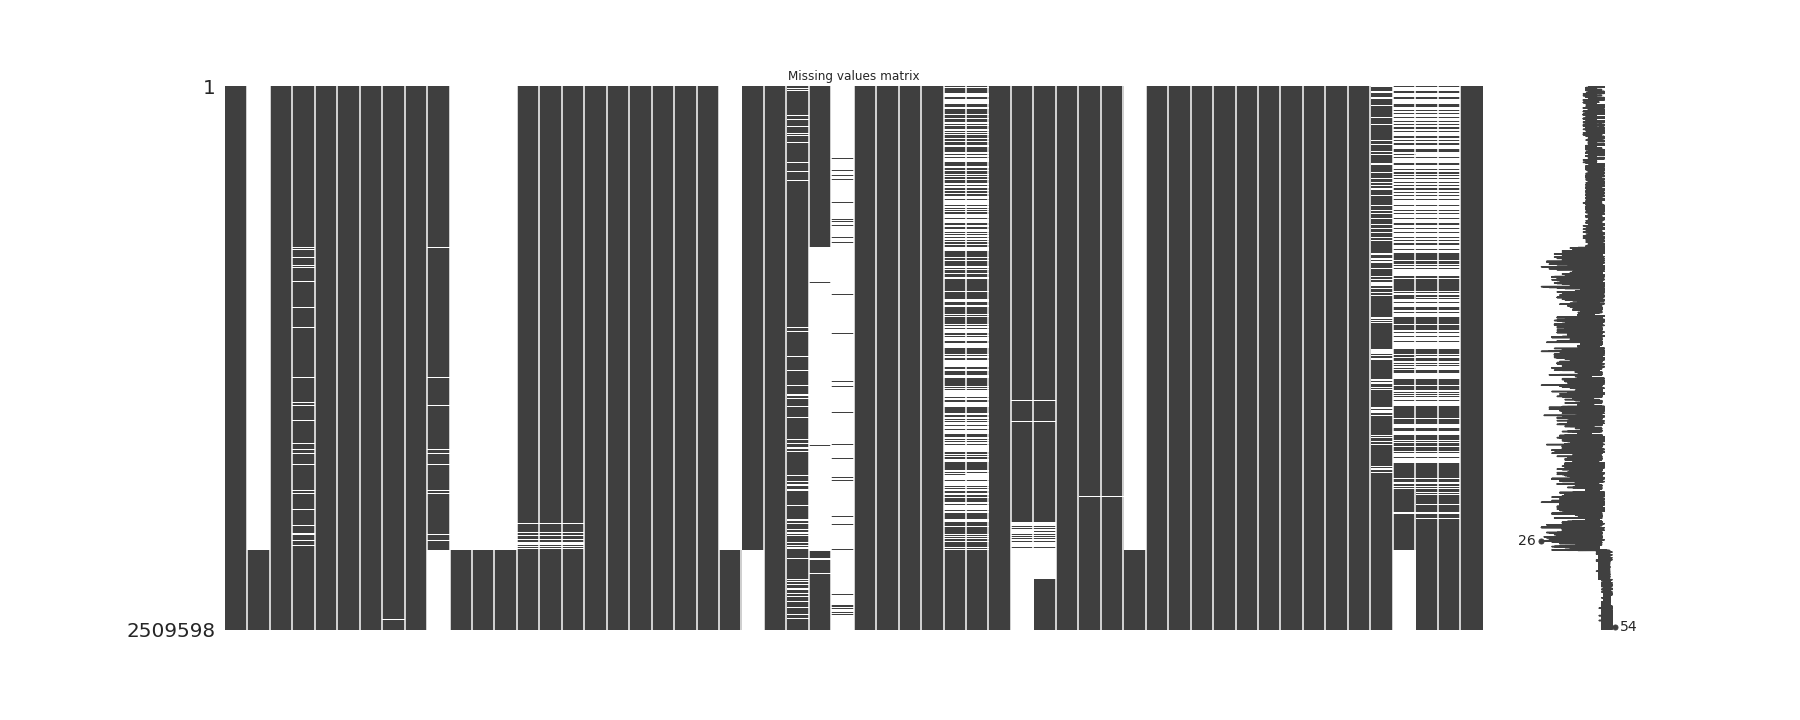

In [2]:
image_path = "./plots/missing_values_matrix.png"
display(Image(filename=image_path))

*We can see from this plot that a lot of columns had missing values, as quantified in the bullet list above. Missing values are less of an issue for the last three years of the dataset.*

#### <a id='feature_engineering'>Feature engineering</a>
*The corresponding notebook is available [here](#TODO - Add link).*
We created some additional features from the available dataset, to make some information more easily interpretable by our predictive models:
- Column 'age' was created by subtracting column 'an_nais' values from the 'an' value.
- We can hypothesize that the time of the year (e.g. vacation departures), the time of the week (e.g. Friday) or the time of the day (e.g. at the usual departure to the office time) potentially convey trend information (e.g. accidents are more serious during departures to vacations, or late at night). To take this hypothesis into account, we derived a sine transform and cosine transform of the columns 'mois', 'jour' and 'hrmn' (which was split into 'heures' and 'minutes') to obtain their temporal cyclical component.
- We created a column 'timestamp' (concatenating columns 'an', 'mois', 'jour ' and 'hrmn') to keep the chronology of the accidents, using it to sort the accidents from the earliest on top of the dataframe to the latest at the bottom of the dataframe.
- We dropped the columns 'timestamp', 'an', 'mois', 'jour', 'heure', 'minute', 'hrmn'.

*The notebook implementing the feature engineering steps described above is available [here](#TODO - Add link).*

#### <a id='data_transformation'>Data transformation</a>
- The ultimate rows containing missing values were dropped.
- The numercial columns 'nbv', 'age' and were standardized.
- The predicted variable 'grav' was remapped and converted to ordinal categorical type.

*The notebook implementing the feature engineering steps described above is available [here](https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/04_feature_engineering.ipynb); the notebook implementing the preprocessing steps described above is available [here](https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/05_preprocess.ipynb)*

#### <a id='eda'>EDA</a>
##### <a id='general_eda'>General EDA</a>
- Most accidents happen because of a side crash, according to column 'col'
- Most accidents happen in broad daylight, according to column 'lum'
- About a third of accidents happen outside of urban areas, according to column column 'agg'
- Most accidents happen outside of crossroads, according to column 'int'
- Most accidents happen in normal atmospheric conditions, according to column 'atm'
- Most accidents happen on small roads (departmental roads or municipal roads), according to column 'catr'
- Most accidents happen on two-way roads, according to column 'nbv'
- The vast majority of accidents happen on roads that don't have a reserved way on the side (e.g. bicycle path), according to column 'vosp'
- The vast majority of accidents happen on flat roads, according to column 'prof'
- The vast majority of accidents happen on straight roads, according to column 'plan'
- One accident out of six happens on wet roads, and the vast majority of the rest five remaining sixth happens on dry roads, according to column 'surf'
- The vast majority of accidents don't happen on a special or specific intrastructure (e.g. bridge, tunnel) according to column 'infra'
- The vast majority of accidents happen right on the road (not on the sidewalk or bycicle path), according to column 'situ'
- The circulation direction is unknown for most of the observations, and in almost equal ascending and descending order for observations that do have this information, according to column 'senc'.
- Most accidents involve cars ("LV" means light vehicle), according to column 'catv'
- According to columns 'obs' and 'obsm'
- The column 'obs' doesn't apply in most of the observations
- Most of the time, accidents happen when hitting another car. The next most frequent occurence is an accident without hitting anything, and the third most frequent is when hitting a pedestrian, according to the columns 'obsm'
- Most crashes are frontal, according to column 'choc'
- Most accidents happen without a specific manoeuver or change in direction, according to column 'manv'
- The vast majority of people involved in accidents were the drivers, according to the column 'place'
- About two thirds of people involved in an accident are male, according to column 'sexe'
- The column 'trajet' has a lot of 0 values, which correspond to missing values. We will drop this column, but reserve the possibility to use it, dropping the rows with missing values, and checking whether the addition of a feature is worth the loss in training data (we doubt it).

- About 60% of the accidents lead to no or minor injuries:
    - 42.92% of the people involved in accidents end up uninjured
    - 19.20% of the people involved in accidents end up with minor injuries
    - 35.27% of the people involved in accidents end up with major injuries
    - 2.61% of the people involved in accidents end up killed

After this general EDA, we are dropping the columns listed below:
- The 'senc' column seems uninformative, on top of being an unlikely information to obtain during an emergency call.
- The column 'place' is more detailed than the column 'catu', but the majority of the values provide information that is already contained in 'catu'. We are dropping 'place' and keeping 'catu'.
- We are dropping 'trajet' as it contains too many missing values.
- The column 'circ' is not supposed to have zero values, we are dropping the rows where this is the case.

*The EDA report on the transformed data is available [here](https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/eda_reports/eda_report.html).*

##### <a id='comparative_eda'>Comparative EDA - investigating differences between fatal and benign crashes</a>
- Frontal crashes are proportionally overrepresented in fatal accidents compared to benign ones, according to the column 'col'
- Crashes happening during the night without public lighting are proportionally overrepresented in fatal accidents compared to benign ones, according to tge column 'lum'
- Most benign crashes (one third) happen within urban centers. On the opposite, about three quarters of the fatal crashes happen outside of urban centers, according to column 'agg'.
- The differentiating power of the type of intersection on gravity seems negligible, according to the column 'int'.
- The differentiating power of the atmospheric conditions on gravity seems negligible, according to the column 'atm'.
- The majority of fatal crashes happen on departmental roads, according to column 'catr'.
- Most fatal accidents happen on one-way roads, according to column 'nbv'.
- Bidirectional roads are slightly more represented in fatal crashes than unidirectional or separated roads, according to column 'circ'.
- The differentiating power due to the presence or absence of special ways (e.g. sidewalk, bicycle path) seems negligible, according to the column 'vosp'.
- Curves on the left or right are slightly more represented in fatal crashes than benign ones, according to column 'plan'.
- The differentiating power of the state of the surface on gravity seems negligible, according to the column 'atm'.
- The differentiating power of the presence or absence of special infratructure (e.g. bridge, tunnel) on gravity seems negligible, according to the column 'infra'.
- Accidents located on the road shoulder are proportionally overrepresented in fatal accidents compared to benign ones, according to column 'situ'.
- Motorcycles, bicycles and mopeds are proportionally overrepresented in fatal accidents compared to benign ones, according to column 'catv'.
- If most fatal crashes don't involve an obstacle, trees, ditches, embankments, rock faces, buildings, walls, poles and bridge columns are types of obstacles that are proportionally overrepresented in fatal accidents compared to benign ones, according to column 'obs'. The vast majority of accidents leading to no injuries don't involve an obstacle at all.
- Column 'obsm' is hard to interpret. it doesn't seem to bring any differentiating power, we will drop it.
- Frontal collisions are proportionally overrepresented in fatal accidents compared to benign ones, according to column 'choc'.
- Swerving left is proportionally overrepresented in fatal accidents compared to benign ones, according to column 'manv'. This makes sense as in France people drive on the right side of the road, so to overtake (when one overtakes usually speeding with limited visibility), one has to swerve left. On highways, left lanes are also more likely to have faster vehicles than right lanes, so there is a higher chance to be hit behind or on the side when moving into the left lane.
- Pedestrians collisions are proportionally overrepresented in fatal accidents compared to benign ones, according to column 'catu'. This makes sense as pedestrians don't have a passenger compartment to absorb collisions and protect them.
- Men are slightly proportionally overrepresented in fatal accidents compared to benign ones, according to column 'sexe'. It might be due to chance, but due to the siwe of our dataset, we doubt it and we do think this column has some differentiating power.
- Older people are proportionally overrepresented in fatal accidents compared to benign ones, according to column 'age'. Younger people might be less experienced, but age being correlated with general health, it is not completely surprising to see that older poeple are less resistant to serious car crashes than younger ones.
- It is hard to deduce anything visually from the cyclical feature graphs alone.

After this comparative EDA, and as justified above, we are dropping the columns 'int', 'atm', 'vosp', 'surf', 'infra' and 'obsm'.

The final columns we are using for our predictive model are the following:

| #   | Column         | Data type |
| --- | -------------- | --------- |
| 0   | col            | float64   |
| 1   | lum            | int64     |
| 2   | agg            | int64     |
| 3   | catr           | float64   |
| 4   | circ           | float64   |
| 5   | nbv            | float64   |
| 6   | prof           | float64   |
| 7   | plan           | float64   |
| 8   | situ           | float64   |
| 9   | catv           | int64     |
| 10  | obs            | float64   |
| 11  | choc           | float64   |
| 12  | manv           | float64   |
| 13  | catu           | int64     |
| 14  | sexe           | int64     |
| 15  | grav           | int64     |
| 16  | age            | float64   |
| 17  | month_sin      | float64   |
| 18  | month_cos      | float64   |
| 19  | DayOfWeek_sin  | float64   |
| 20  | DayOfWeek_cos  | float64   |
| 21  | TimeOfDay_sin  | float64   |
| 22  | TimeOfDay_cos  | float64   |


*The EDA report on the dataset filtered for "killed" occurences is available [here](https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/eda_reports/eda_report_killed.html); the EDA report on the dataset filtered for "killed" occurences is available [here](https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/eda_reports/eda_report_uninjured.html).*


## <a id='modeling'>Modeling</a>
For simplicity, we opted for a binary approach at first. So values 1 and 2 (uninjured and minor injuries) become 0 and values 3 and 4 (serious injuries and killed) become 1. We are taking this approach to try and build a model that performs well while remaining simple, and complexify the approach step by step.

Combining serious injuries and killed observations also solves the imbalance problem in a first time: while accidents where the person were killed are fortunately a minority of the cases in the dataset (2.71%), serious injuries are more common (36.36%). Therefore, after the combination mentioned in the paragraph above, we end up with a more balanced dataset (39.07% serious injuries vs 60.93% minor injuries)

### <a id='base_model'>Base model</a>
The most common value in the data is 0 (minor injury), as 60.93% of the data is categorized as 0. We can therefore consider our base model to be the one that predicts that all accidents are leading to minor injuries, and we would obtain an accuracy of 60.93%. However, this metric is problematic for two reasons:
- The whole point of the model is to be able to predict when an accident requires emergency services equipped for major injuries: using this base model, emergency services would show up underquipped for 100% of the major injuries cases.

### <a id='modeling_approach'>Modeling approach</a>
Considering the state of our problem (trying to predict a class) and of our dataset (mainly categorical, but with some numerical and cyclical temporal features), we are going to try the following models:
- **Logistic Regression:**
    - Logistic Regression train really fast, especially on large datasets. It providescoefficients that are easily interpretable and enable a deeper understanding of the impact of individual features on the prediction. However, it assumes a linear relationship between features and the target, which may not always be the case. It also requires requires one-hot encoding for categorical features, which can increase the dataset dimensionality (which can be especially dangerous when using a subset of the full dataset like we're doing here). The advantage is that we can always train the model on a much bigger dataset as it is one of the fastest algorithms to train on our dataset.
- **XGBoost (Extreme Gradient Boosting):**
    - This boosting model performs well on many different datasets, and supports both categorical and numerical features without extensive preprocessing. It is robust to missing data and supports class penalization through weight adjustments.
    - However, it can take longer to train than simpler models (e.g. Logistic Regression) and needs fine tuning to prevent overfitting.
- **Random Forest:**
    - This ensemble model combines several decision trees, preventing overfitting. It handles both categorical and numerical features without the need for one-hot encoding. It is robust to outliers and missing values.can also be paralellized, making it faster for large datasets.
    - However, it requires proper class balancing techniques to handle imbalanced datasets, becomes more memory intensive with larger trees, and interpreting the feature importance can be come a challenges in high-dimensional dataset.ation can be challenging in high-dimensional datasets.
- **Support Vector Machine (SVM):**
    - Support Vector Machines are generally effective in high-dimensional spaces. It can handle categorical and numerical features if they are properly processed.
    - However, the training time becomes really high for larger datasets (which is our case). It requires proper scaling and preprocessing of numerical features (which is why we standardized them). It usually performs badly on imbalanced dataset without proper class penalization.

For demonstration purposes, and because the training times quickly get out of hand considering the time allocated for this specific work, we are training on a subset of the dataset, totaling about 20,000 observations. We are splitting the data into training, validation and testing sets. We are using a grid search to test several hyperparameter combinations for our models:
- For random forest, we are penalizing predicting 1 as 0 twice as heavily as predicting 0 as 1, and trying the following combination of hyperparameters:
    - 'clf__n_estimators': 100, 200, 300
    - 'clf__max_depth': None, 10, 20
    - 'clf__min_samples_split': 2, 5, 10
    - 'clf__min_samples_leaf': 1, 2, 4
- For XGBoost, we are using a tree method, and the following combination of hyperparameters:
    - 'clf__n_estimators': 100, 200, 300,
    - 'clf__max_depth': 3, 6, 9,
    - 'clf__learning_rate': 0.01, 0.1, 0.3
- For logistic regression, we are using the following combination of hyperparameters:
    - 'clf__C': 0.1, 1, 10,
    - 'clf__solver': "liblinear", "lbfgs"
 
The Grid Search is cross validated on 5 folds, but if we ever take into account more observations (our full dataset has more than 2M rows), cross-validation might prove less useful.

## Evaluation
We can find a better metric than accuracy, that is more expressive of the objective of the model. We are trying to help emergency services provide the best response possible to an accident, and sending an underequipped squad to an accident that turns out to be more serious than predicted, is a lot more expensive (loss of life) than sending an overequipped squad to an accident that turns out to be minor. For this reason, we want to heavily penalized predicting 0 when the actual value is 1, and we want to focus on the recall metric when evaluating our results (although we will still look at other metrics for information purposes).

Each model is first trained and then evaluated on the evaluation set. The best model and best hyperparameters are then used to retrain the model on the training and evaluation set, before obtaining final results with predictions on the testing set.

| Model               | Best model parameters                                                                                                           | Dataset        | F1-score | Precision | Recall  | ROC-AUC | Training Time |
|---------------------|--------------------------------------------------------------------------------------------------------------------------------|----------------|----------|-----------|---------|--------|---------------|
| Logistic Regression | {'clf\_\_C': 10, 'clf\_\_solver': 'lbfgs'}                                                                                          | Validation Set | 0.3818   | 0.5921    | 0.2818  | 0.5807 | 0.83s         |
| Logistic Regression | {'clf\_\_C': 10, 'clf\_\_solver': 'lbfgs'}                                                                                          | Test Set       | 0.3703   | 0.5816    | 0.2716  | 0.5734 |               |
| XGBoost             | {'clf\_\_learning\_rate': 0.3, 'clf\_\_max\_depth': 6, 'clf\_\_n_estimators': 100}                                                     | Validation Set | 0.8236   | 0.8781    | 0.7754  | 0.8543 | 19.32s        |
| XGBoost             | {'clf\_\_learning\_rate': 0.3, 'clf\_\_max\_depth': 6, 'clf\_\_n_estimators': 100}                                                     | Test Set       | 0.5666   | 0.6127    | 0.5269  | 0.6570 |               |
| Random Forest       | {'clf\_\_class\_weight': {0: 1, 1: 3}, 'clf\_\_max\_depth': 10, 'clf\_\_min\_samples\_leaf': 4, 'clf\_\_min\_samples\_split': 2, 'clf\_\_n\_estimators': 200} | Validation Set | 0.6524   | 0.5024    | 0.9301  | 0.6796 | 518.10s       |
| Random Forest       | {'clf\_\_class\_weight': {0: 1, 1: 3}, 'clf\_\_max\_depth': 10, 'clf\_\_min\_samples\_leaf': 4, 'clf\_\_min\_samples\_split': 2, 'clf\_\_n\_estimators': 200} | Test Set       | 0.6157   | 0.4676    | 0.9009  | 0.6228 |               |
| Support Vector Machine | {'clf\_\_C': 10, 'clf\_\_gamma': 0.1, 'clf\_\_kernel': 'rbf'}                                                                      | Validation Set | 0.9710   | 0.9764    | 0.9656  | 0.9756 | 4173.83s      |
| Support Vector Machine | {'clf\_\_C': 10, 'clf\_\_gamma': 0.1, 'clf\_\_kernel': 'rbf'}                                                                      | Test Set       | 0.5064   | 0.5324    | 0.4829  | 0.6059 |               |

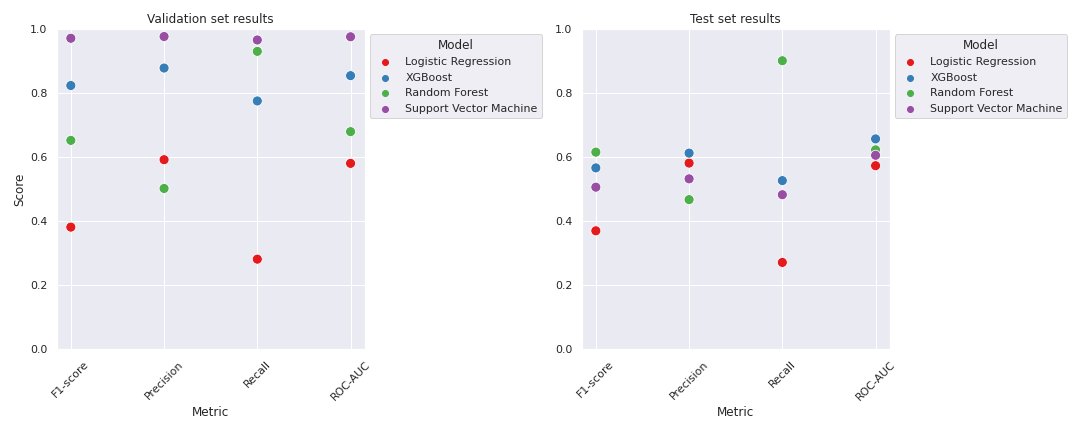

In [3]:
image_path = "./plots/validation_vs_testing_metrics.png"
display(Image(filename=image_path))

We notice a few things:
- Unsurprisingly, the Support Vector Machine model is the longest to train. 20,000 rows is already pretty big for an SVM model. Additionally, despite performing really well on the evaluation test it's the best model according to the sole evaluation metrics), it completely fails the evaluation on the testing set (becoming one of the worst performing models). We suspect the model overfits the training set and can't generalize learnings to the testing set.
- Random Forest is the second model that takes the longest time, but it's worth it in this case since this model performs best on the recall metric, and is therefore useful if we absolutely want to avoid sending underequipped emergency teams. The performances of the final model are slightly degraded on the testing set, but we still get 0.90 as a recall score.
- XGBoost exhibits mediocre performances on all evaluation metrics, except the AUC Score which is among the highest on the testing set.
- Logistic regression performs terribly, especially on recall. Unfortunately, it was also the fastest model to train.

*The notebook implementing the modeling and evaluation steps described above is available [here](https://github.com/Hadrien-lcrx/nb_georgia_tech/blob/main/lab/isye6740/project/06_modeling.ipynb).*

## Conclusion
For now, our model of choice if an ensemble model: the Random Forest, exhibiting the best score on recall while maintaining an honorable F1 score. The best model has the following parameters:
- Class weight: {0: 1, 1: 3}
- Max depth: 10
- Minimum number of samples per leaf: 4
- Minimum of samples to split: 2
- Number of trees: 200

## <a id='next_steps'>Next steps</a>
We first would like to take the time to use more of the training set to train and fit our models, and then to see if we can actually use the four original classes instead of the two we engineered for the purpose of this work. Spending more time fine tuning the Logistic Regression model might be time well spent, because if we manage to improve the performance, we can get very interpretable insight about the impact each feature has on predictions. Since the model is the fastest to train, it allows us to experiment with a more varied parameter grid and on training wth a bigger subset of the data.

We would like to explore clustering opportunities:
- Model selection: We will try K-Means, density-based clustering, DBSCAN and OPTICS to identify spatio-temporal patterns. We will consider hierarchical clustering, or Gaussian mixture models. We will also consider hierarchical clustering Gaussian mixture models when incorporating contextual factors, and sequence-based clustering, sequential pattern mining, as well as hidden markov models for sequential clustering. If time permits, the deep learning approaches could involve autoencoders, variational autoencoders and deep embedded clustering to see which approach yields better results in identifying complex patterns in the data, and how interpretable the results are.
- Evaluation: We will use the elbow method, the silhouette method and the Davies-Bouldin index to evaluate the quality of the accident clusters. We will also interpret the clusters considering our knowledge of the data to try and extract meaningful interpretation, whether it’s about accident patterns, accident prone locations, contextual characteristics or temporal trends. We will also, whenever possible, visualize these results on a map or on a time chart, to highlight and interpret results visually.

We would also be interested in preserving the timestamp element and try a temporal analysis angle on the dataset.

These clustering and temporal models could, depending on their performance and results, be incorporated in an ensemble model, that might prove more robust than the single model approach we have completed in this notebook.

___
## <a id='annexes'>Annexes</a>
### <a id='annex_01'>Annex 1 - Columns from the original dataset</a>

The dataset is made of data sourced from four different sections:
1. The *characteristics* section describing the general circumstances of the accident
2. The *locations* section describing the main location of the accident (even if it happened at an intersection)
3. The *vehicles* section providing additional details about the vehicles involved
4. The *users* section providing additional details about the persons involved

**Charateristics:**
- `Num_Acc`: Accident unique ID
- `an`: Year the accident happened
- `mois`: Month the accident happened
- `jour`: Day the accident happened
- `hrmn`: Hour and minute in military time
- `lum`: Light: Lighting conditions in which the accident occurred:
    - 1 – Broad daylight
    - 2 – Sunrise
    - 3 – At night without public lighting
    - 4 – At night with public lighting turned off
    - 5 – At night with public lighting turned on
- `agg`: Localization:
    - 1 – Outside of an urban center
    - 2 – Within an urban center
- `int`: Intersection:
    - 1 – Outside of an intersection
    - 2 – Intersection in X shape
    - 3 – Intersection in T shape
    - 4 – Intersection in Y shape
    - 5 – Intersection with more than 4 branches
    - 6 – Roundabout
    - 7 – Square
    - 8 – Railway crossing
    - 9 – Other 
- `atm`: Weather conditions:
    - -1 – Missing
    - 1 – Normal
    - 2 – Light rain
    - 3 – Heavy rain
    - 4 – Snow - hail
    - 5 – Fog - smoke
    - 6 – Strong wind - storm
    - 7 – Blinding weather
    - 8 – Cloudy
    - 9 – Other
- `col`:
    - Crash type:
    - -1 – Missing
    - 1 – Two vehicles - front
    - 2 – Two vehicles – back
    - 3 – Two vehicles – side
    - 4 – Three vehicles and more – chain
    - 5 – Three vehicles and more - multiple crashes
    - 6 – Other
    - 7 – None
- `com`: City INSEE code (might be the zip code)
- `adr`: Postal address: variable filled for accidents that occurred within urban centers
- `gps`: One character indicating the geographical zone:
    - M = Mainland
    - A = Martinique ou Guadeloupe
    - G = French Guiana
    - R = Réunion
    - S = St Pierre et Miquelon
    - Y = Mayotte
    - P = French Polynesia
    - W = Wallis and Futuna
    - C = New Caledonia
    - T = French Southern and Antarctic Lands
- `lat`: Latitude
- `long`: Longitude
- `dep`: Department INSEE code

**Locations:**
- `Num_Acc`: Accident unique ID
- `catr`:
    - 1 - Freeway
    - 2 - Highway
    - 3 - Departmental roads
    - 4 - Communcal roads
    - 5 - Outside of public roads network
    - 6 - Parking open to public circulation
    - 9 – Other
- `voie`: Road number
- `v1`: Numerical road ID
- `v2`: Alpha numerical road ID
- `circ`: Traffic pattern:
    - -1 – Missing
    - 1 – One way
    - 2 – Bidirectional
    - 3 – Separate roads
    - 4 – Variable assignment roads
- `nbv`: Total number of roads 
- `vosp`: Signals the existence of a special roadway, even if the accident didn't happen on that specific special roadway
    - -1 – Missing
    - 0 – Not applicable
    - 1 – Bicycle path
    - 2 – Bicycle lane
    - 3 – Reserved road 
- `prof`: Describes the slope pattern where the accident occurred:
    - -1 – Missing
    - 1 – Flat
    - 2 – Slope
    - 3 – Top of the slope
    - 4 – Bottom of the slope
- `pr`: ID of the upstream distance marker (-1 means missing)
- `pr1`: Distace to the upstream distance marker (-1 means missing)
- `plan`: Plan drawing:
    - -1 – Missing
    - 1 – Straight
    - 2 – Swerving left
    - 3 – Swerving right
    - 4 – S shape
- `lartpc`: Width of the median strip if there is one (in meters)
- `larrout`: Width of the road including the emergency stopping lanes, median strips and parking spaces (in meters)
- `surf`: State of the surface:
    - -1 – Missing
    - 1 – Normal (dry)
    - 2 – Wet
    - 3 – Puddles
    - 4 – Flooded
    - 5 – Covered with snow
    - 6 – Mud
    - 7 – Icy
    - 8 – Fatty substance - oil
    - 9 – Other
- `intra`: Infrastructure:
    - -1 – Missing
    - 0 – None
    - 1 – Tunnel
    - 2 – Bridge
    - 3 – Interchange
    - 4 – Railway
    - 5 – Equipped crossroad
    - 6 – Pedestrian zone
    - 7 – Toll zone
    - 8 – Construction site
    - 9 – Other
- `situ`: Road location:
    - -1 – Missing
    - 0 – None
    - 1 – On roadway
    - 2 – On emergency lane
    - 3 – On road shoulder
    - 4 – On sidewalk
    - 5 – On bicycle lane
    - 6 – On other special lane
    - 8 – Other
- `vma`: Maximum speed authorized at the location and time of the accident

**Users:**
- `Num_Acc`: Accident unique ID
- `id_usagers`: User unique ID
- `id_vehicule`: Vehicle unique numeric ID
- `num_veh`: Vehicle unique alphanumeric ID by accident
- `place`: Place occupied by the user in the vehicle when the accident occurred, according to provided drawing
    - (check drawing)
    - 10 – Pedestrian (non-applicable) 
- `catu`: User type:
    - 1 – Driver
    - 2 – Passenger
    - 3 – Pedestrian
- `grav`: User injuries gravity:
    - 1 – Uninjured
    - 2 – Killed
    - 3 – Serious injuries (hospitalized)
    - 4 – Minor injuries (not hospitalized) 
- `sexe`: User sex:
    - 1 – Male
    - 2 – Female 
- `an_nais`: User year of birth. 
- `trajet`: Reason for driving when the accident occurred:
    - -1 – Missing
    - 0 – Missing
    - 1 – Home - Work
    - 2 – Home - School
    - 3 – Groceries / purchases
    - 4 – Professional use
    - 5 – Leisure ride
    - 9 – Other
- `secu`: Security equipments (used up to 2018):
    - Existing
    - Used
- `secu1`: Presence and use of security equipment:
    - -1 – Missing
    - 0 – None
    - 1 – Seatbelt
    - 2 – Helmet
    - 3 – System for kids
    - 4 – Reflective vest
    - 5 – Airbag (2RM/3RM)
    - 6 – Gloves (2RM/3RM)
    - 7 – Gloves + Airbag (2RM/3RM)
    - 8 – Indeterminate
    - 9 – Other
- `secu2`: Presence and use of security equipment:
    - -1 – Missing
    - 0 – None
    - 1 – Seatbelt
    - 2 – Helmet
    - 3 – System for kids
    - 4 – Reflective vest
    - 5 – Airbag (2RM/3RM)
    - 6 – Gloves (2RM/3RM)
    - 7 – Gloves + Airbag (2RM/3RM)
    - 8 – Indeterminate
    - 9 – Other
- `secu3`: Presence and use of security equipment:
    - -1 – Missing
    - 0 – None
    - 1 – Seatbelt
    - 2 – Helmet
    - 3 – System for kids
    - 4 – Reflective vest
    - 5 – Airbag (2RM/3RM)
    - 6 – Gloves (2RM/3RM)
    - 7 – Gloves + Airbag (2RM/3RM)
    - 8 – Indeterminate
    - 9 – Other
- `locp`: Pedestrian location:
    - -1 – Missing
    - 0 – Not applicable
    - 1 – On the road at +50m from pedestrian crossing
    - 2 – On the road at -50m from pedestrian crossing
    - 3 – On pedestrian crossing without light signal
    - 4 – On pedestrian crossing with light signal
    - 5 – On sidewalk
    - 6 – On road shoulder
    - 7 – On refuge or emergency lane
    - 8 – On side road
    - 9 – Unknown
- `actp`: Pedestrian action:
    - -1 – Missing
    - 0 – Missing or not applicable
    - 1 – In the colliding vehicle direction
    - 2 – Opposite to the colliding vehicle direction
    - 3 – Crossing
    - 4 – Masked
    - 5 – Playing / running
    - 6 – With animal
    - 9 – Other
    - A – Getting up or down from the vehicle
    - B – Unknown
- `etatp`: Signals whether the pedestrian was alone or not:
    - -1 – Missing
    - 1 – Alone
    - 2 – With someone
    - 3 – With a group

**Vehicles:**
- `Num_Acc`: Accident unique ID
- `id_vehicule`: Vehicle unique numeric ID
- `num_veh`: Vehicle unique alphanumeric ID by accident 
- `senc`: Traffic flow direction:
    - -1 – Missing
    - 0 – Unknown
    - 1 – Ascending postal address number
    - 2 – Descending postal address number
    - 3 – No point of reference
- `catv`: Vehicle category:
    - 00 – Indeterminate
    - 01 – Bicycle
    - 02 – Mopped <50cm3
    - 03 – Mobility scooter
    - 04 – Unused since 2006 (registered scooter)
    - 05 – Unused since 2006 (mopped)
    - 06 – Unused since 2006 (side-car)
    - 07 – Light vehicle
    - 08 – Unused since 2006 (Light vehicle + caravan)
    - 09 – Unused since 2006 (Light vehicle + trailer)
    - 10 – Utility vehicle 1,5T <= PTAC <= 3,5T with or without trailer
    - 11 – Unused since 2006 (Utility vehicle + caravane)
    - 12 – Unused since 2006 (Utility vehicle + trailer)
    - 13 – Heavy truck 3,5T <PTCA <= 7,5T
    - 14 – Heavy truck > 7,5T
    - 15 – Heavy truck > 3,5T + trailer
    - 16 – Road tractor
    - 17 – Road tractor + semitrailer
    - 18 – Unused since 2006 (public transport)
    - 19 – Unused since 2006 (tramway)
    - 20 – Special vehicle
    - 21 – Farming tractor
    - 30 – Scooter < 50 cm3
    - 31 – Mopped > 50 cm3 et <= 125 cm3
    - 32 – Scooter > 50 cm3 et <= 125 cm3
    - 33 – Motorcycle > 125 cm3
    - 34 – Scooter > 125 cm3
    - 35 – Light quad bike (<= 50 cm3)
    - 36 – Heavy quad bike (> 50 cm3)
    - 37 – Bus
    - 38 – Coach
    - 39 – Train
    - 40 – Tramway
    - 41 – 3RM <= 50 cm3
    - 42 – 3RM > 50 cm3 <= 125 cm3
    - 43 – 3RM > 125 cm3
    - 50 – Personal mobility device (motorized)
    - 60 – Personal mobility device (not motorized)
    - 80 – Electric bicycle
    - 99 – Other
- `obs`: Fixed obstacle hit:
    - -1 – Missing
    - 0 – Not applicable
    - 1 – Parked vehicle
    - 2 – Tree
    - 3 – Metal safety barrier
    - 4 – Concrete safety barrier
    - 5 – Other safety barrier
    - 6 – Building, wall, bridge column
    - 7 – Road sign or emergency call station
    - 8 – Pole
    - 9 – Street furniture
    - 10 – Railing
    - 11 – Island, refuge, high distancem marker
    - 12 – Sidewalk curb
    - 13 – Ditch, embankment, stone wall
    - 14 – Other fixed obstacle on road
    - 15 – Other fixed obstacle on sidewalk or road shoulder
    - 16 – Road exit without obstacle
    - 17 – Aqueduct nozzle
- `obsm`: Mobile obstacle hit:
    - -1 – Missing
    - 0 – None
    - 1 – Pedestrian
    - 2 – Vehicle
    - 4 – Rail vehicle
    - 5 – Animal (domestic)
    - 6 – Animal (wild)
    - 9 – Other
- `choc`:
    - Initial colliding point:
    - -1 – Missing
    - 0 – None
    - 1 – Front
    - 2 – Front right
    - 3 – Front left
    - 4 – Back
    - 5 – Back right
    - 6 – Back left
    - 7 – Right
    - 8 – Left
    - 9 – Multiple collisions (flips) 
- `manv`: Main maneuver before accident
    - -1 – Missing
    - 0 – Unknown
    - 1 – No direction change
    - 2 – Same direction, same lane
    - 3 – Between two lanes
    - 4 – In reverse 
    - 5 – In opposite direction
    - 6 – Crossing the median strip
    - 7 – In the bus lane, same direction
    - 8 – In the bus lane, opposite direction
    - 9 – Inserting
    - 10 – Turning around
    - 11 – Changing lanes left
    - 12 – Changing lanes right
    - 13 – Swerving left
    - 14 – Swerving right
    - 15 – Turning left
    - 16 – Turning right
    - 17 – Overtaking left
    - 18 – Overtaking right
    - 19 – Crossing the road
    - 20 – Parking
    - 21 – Dodging
    - 22 – Opening cardoor
    - 23 – Stopped (not parked)
    - 24 – Parked (with users)
    - 25 – Driving on sidewalk
    - 26 – Other 
- `motor`: Vehicle motor type:
    - -1 – Missing
    - 0 – Unknown
    - 1 – Hydrocarbon
    - 2 – Hybrid
    - 3 – Electric
    - 4 – Hydrogen
    - 5 – Humman
    - 6 – Other
- `occutc`: Number of people in the public transport 

In [4]:
!jupyter nbconvert --to html --TemplateExporter.exclude_input=True Lacroix_Hadrien_final_project_report.ipynb

[NbConvertApp] Converting notebook Lacroix_Hadrien_final_project_report.ipynb to html
[NbConvertApp] Writing 719207 bytes to Lacroix_Hadrien_final_project_report.html
